# Group level windowed mean analysis

This notebook demonstrates a simple analysis of epoched EEG data at group level. Refer to the `windowed_mean_subject_level` notebook for a similar analysis at the subject level.

In [88]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from scipy import stats
from pathlib import Path

## Loading the data
First, we load in the data from the three participants and save them in a variable called `all_epochs`, which is a list of `mne.Epochs` objects.

In [89]:
# Define the directory where your saved epoch files are located
data_path = Path("/Users/lina/Documents/GitHub/ore_EEG/epochs")

# Initialize an empty list to store epochs objects
all_epochs = []

# Iterate over your saved files and load them into epochs objects
for participant in ["own_sub1", "own2_ah"]:
    # Load epochs data from each file
    epochs = mne.read_epochs(data_path / f"epochs_{participant}-epo.fif", verbose=False, preload=True)
    
    # Only keep EEG channels
    epochs.pick_types(eeg=True)
    
    # Append the loaded epochs object to the list
    all_epochs.append(epochs)

# Check the type and length of the list of epochs objects
print(type(all_epochs))  # We have now created a list of epochs objects
print(len(all_epochs))    # We have 2 epochs objects in the list

# Access the first epochs object in the list
print(type(all_epochs[0]))  # We can access the first epochs object in the list which is an Epochs object


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<class 'list'>
2
<class 'mne.epochs.EpochsFIF'>


### Preparing the data for t-test
The aim is to conduct a t-test on the averaged data over the chosen channels and timepoints and participants, to establish whether there is a difference between the two conditions.

We can use the `get_data()` function to get the numerical values of the signal for the t-test. tmin and tmax are used to define the time window, and the picks are the channels that we expect to see an effect in.

Here, I have arbitrarily chosen the time window from 0.2 to 0.4 seconds, and the channels `["Fz", "Cz", "Pz", "Oz"]`. When conducting your own analysis, refer to literature to find a relevant time window and channels for your analysis.

In [90]:
# chosen channels
picks = ["Oz"]

# time window in seconds
tmin = 0.16
tmax = 0.2

In [91]:
# create empty arrays to store the data 
white = np.array([])
other = np.array([])

# 'happy/white', 'neutral/white', 'sad/white', 'happy/black', 'neutral/black', 'sad/black', 'happy/asian', 'sad/asian']  # all image events 

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_white = epochs['happy/black', 'neutral/black', 'sad/black', 'happy/asian', 'sad/asian']
    epochs_other = epochs['happy/white', 'neutral/white', 'sad/white']

    # extract the data for the time window and channels of interest
    data_white = epochs_white.get_data(picks = picks, tmin = tmin, tmax = tmax)
    data_other = epochs_other.get_data(picks = picks, tmin = tmin, tmax = tmax)

    # calculate the mean over the time, channel and trial dimension (axis 0, 1 and 2)
    data_white_mean = np.mean(data_white, axis=(0, 1, 2))
    data_other_mean = np.mean(data_other, axis=(0, 1, 2))

    # append the data to the arrays
    white = np.append(white, data_white_mean)
    other = np.append(other, data_other_mean)

print(white)
print(other)

[-1.54920379e-06 -1.54224718e-06]
[-1.68417730e-06 -1.57603472e-06]


Now we have two datapoints per participant, one for each condition. We can use the `scipy.stats.ttest_rel()` function to run a paired t-test on the data. This function takes two arrays, and returns the t-value and p-value.

In [92]:
# now using paired t-test
stats.ttest_rel(white, other)

TtestResult(statistic=1.667830292053759, pvalue=0.34384574920802324, df=1)

### Plotting the results

#### Preparing the data for plotting

In [93]:
import numpy as np

# Initialize empty arrays to store the data
white = np.array([])
other = np.array([])

# Define the event categories
white_events = ['happy/white', 'neutral/white', 'sad/white']
other_events = ['happy/black', 'neutral/black', 'sad/black', 'happy/asian', 'sad/asian']

for epochs in all_epochs: # Loop over the list with epochs for each participant

    # Extract the trials for white and other events
    epochs_white = epochs[white_events]
    epochs_other = epochs[other_events]

    # Extract the data for the time window and channels of interest
    data_white = epochs_white.get_data(picks=picks, tmin=tmin, tmax=tmax)
    data_other = epochs_other.get_data(picks=picks, tmin=tmin, tmax=tmax)

    # Calculate the mean over the time, channel, and trial dimensions
    data_white_mean = np.mean(data_white, axis=(0, 1, 2))
    data_other_mean = np.mean(data_other, axis=(0, 1, 2))

    # Append the data to the arrays
    white = np.append(white, data_white_mean)
    other = np.append(other, data_other_mean)

print(white)
print(other)


[-1.68417730e-06 -1.57603472e-06]
[-1.54920379e-06 -1.54224718e-06]


#### Plotting the results

ValueError: x and y must have same first dimension, but have shapes (901,) and (2,)

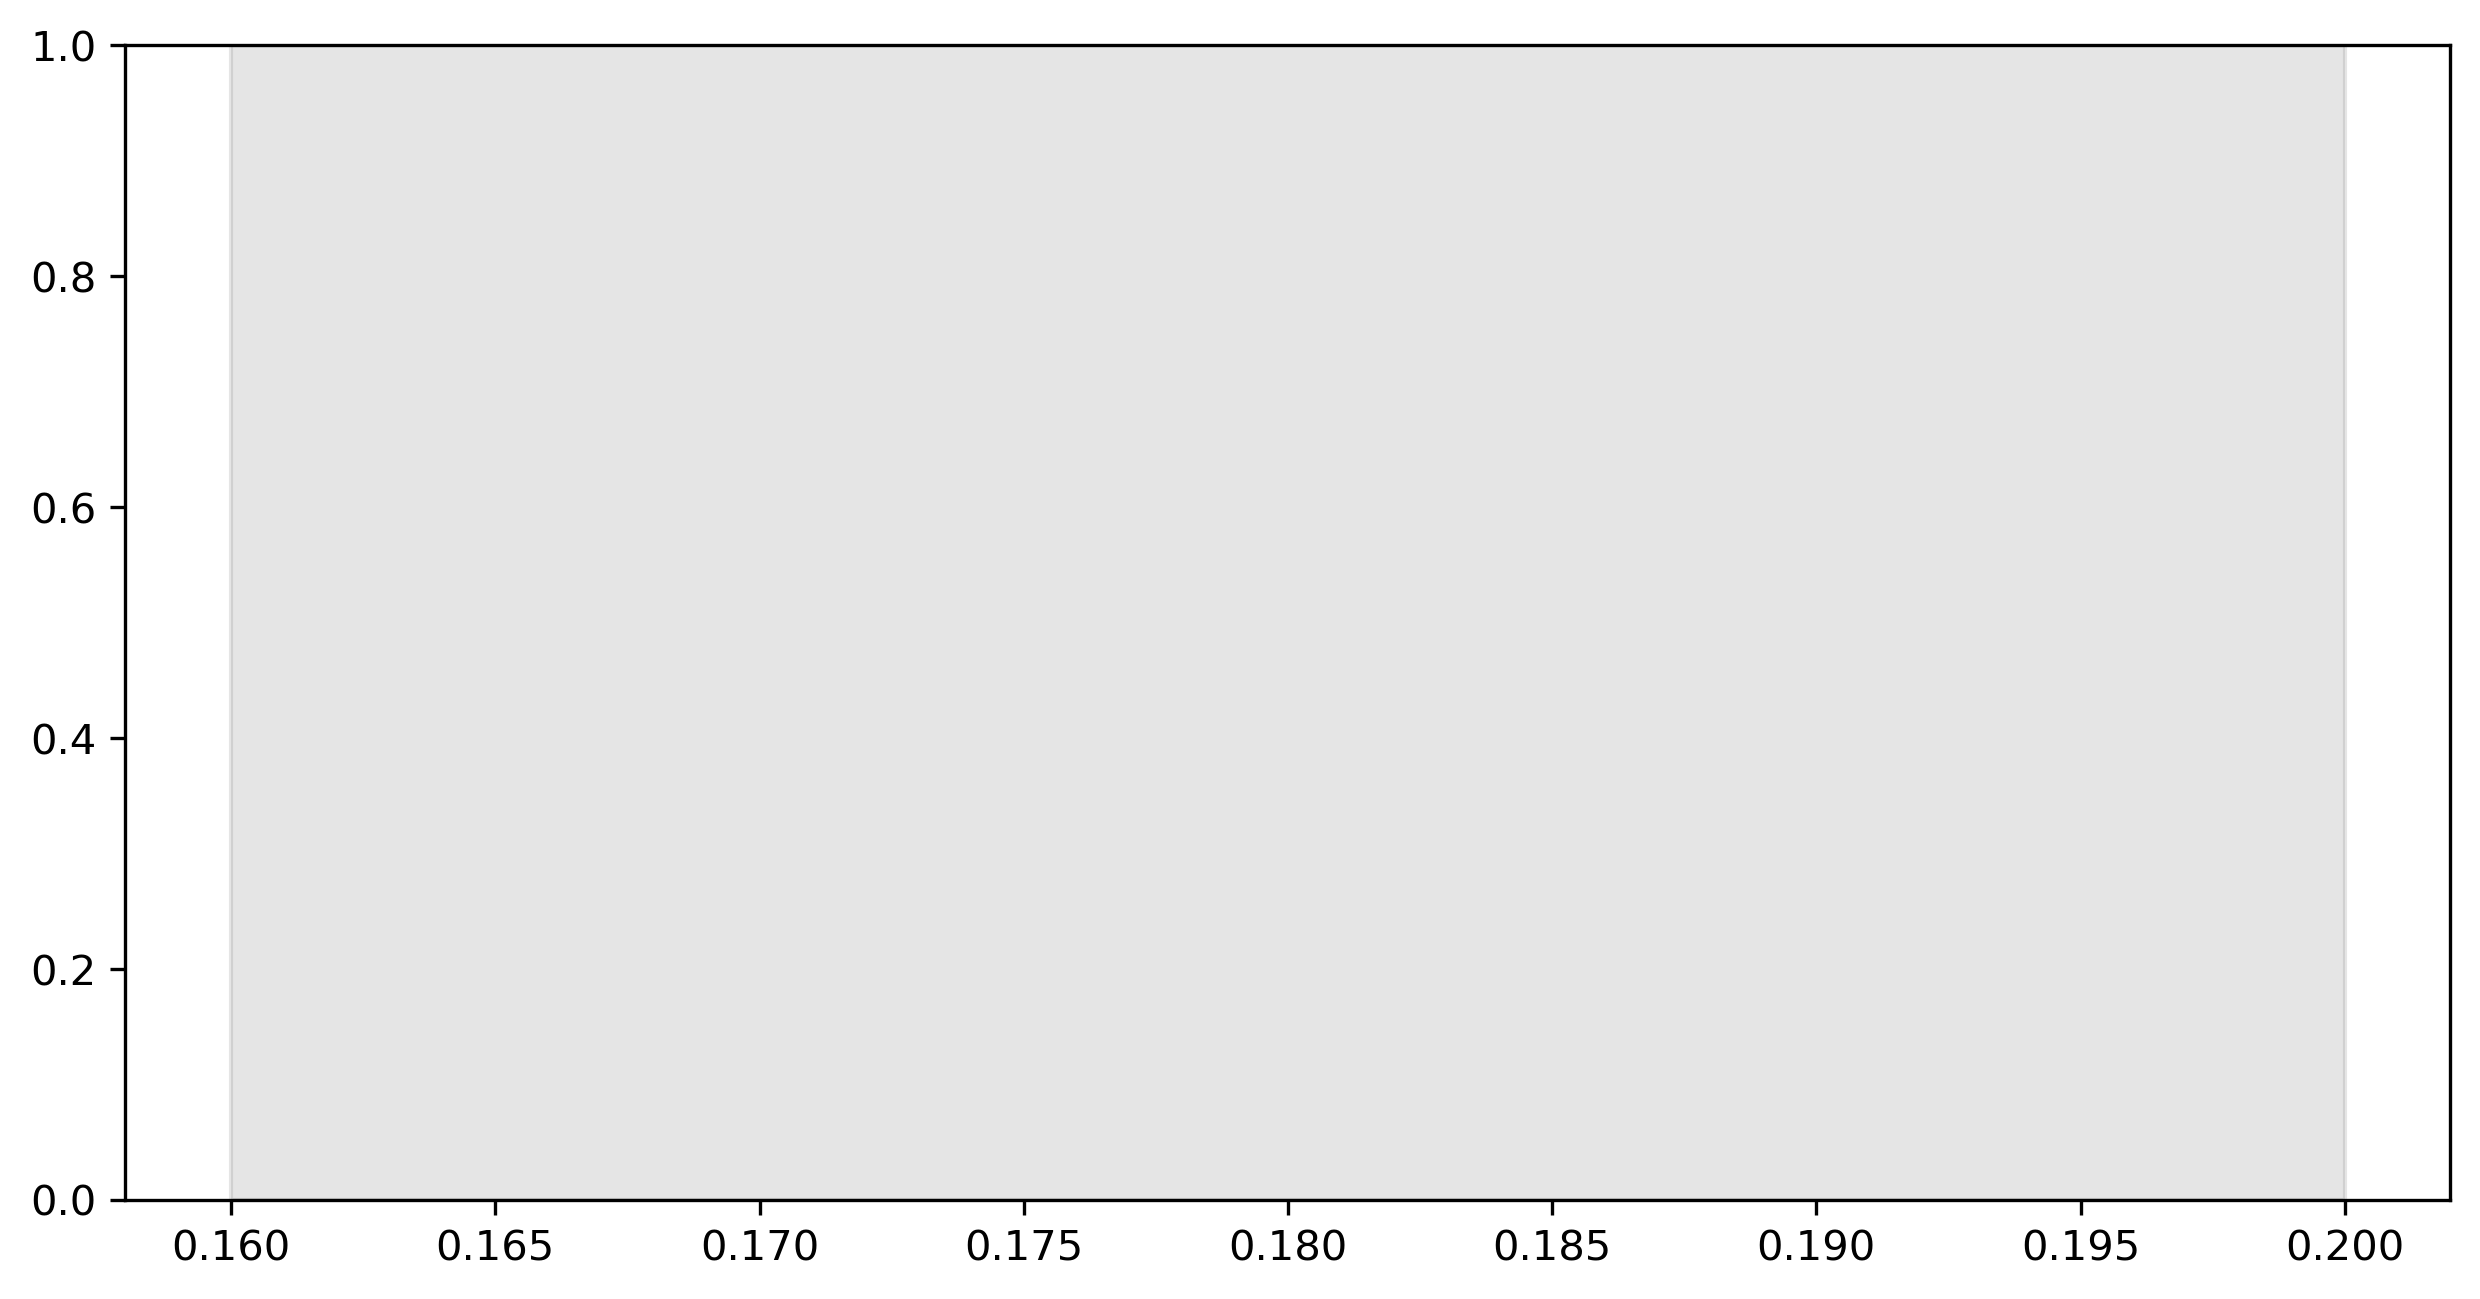

In [94]:
### PLOTTING HERE DOES NOT WORK


# Plotting averaged timecourses for each participant
colours = ["forestgreen", "goldenrod"]

# Extract the times from the first epoch
times = all_epochs[0].times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# Plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# Plot the time courses for each participant
for participant in range(len(all_epochs)):
    ax.plot(times, other[participant:,], label=f"Other ({participant+1})", linestyle="--", color=colours[participant % len(colours)], linewidth=1)
    ax.plot(times, white[participant:,], label=f"White ({participant+1})", linestyle="-", color=colours[participant % len(colours)], linewidth=1)

# Vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP for each participant (Fz, Cz, Pz, Oz)")
ax.legend()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (901,) and (1,)

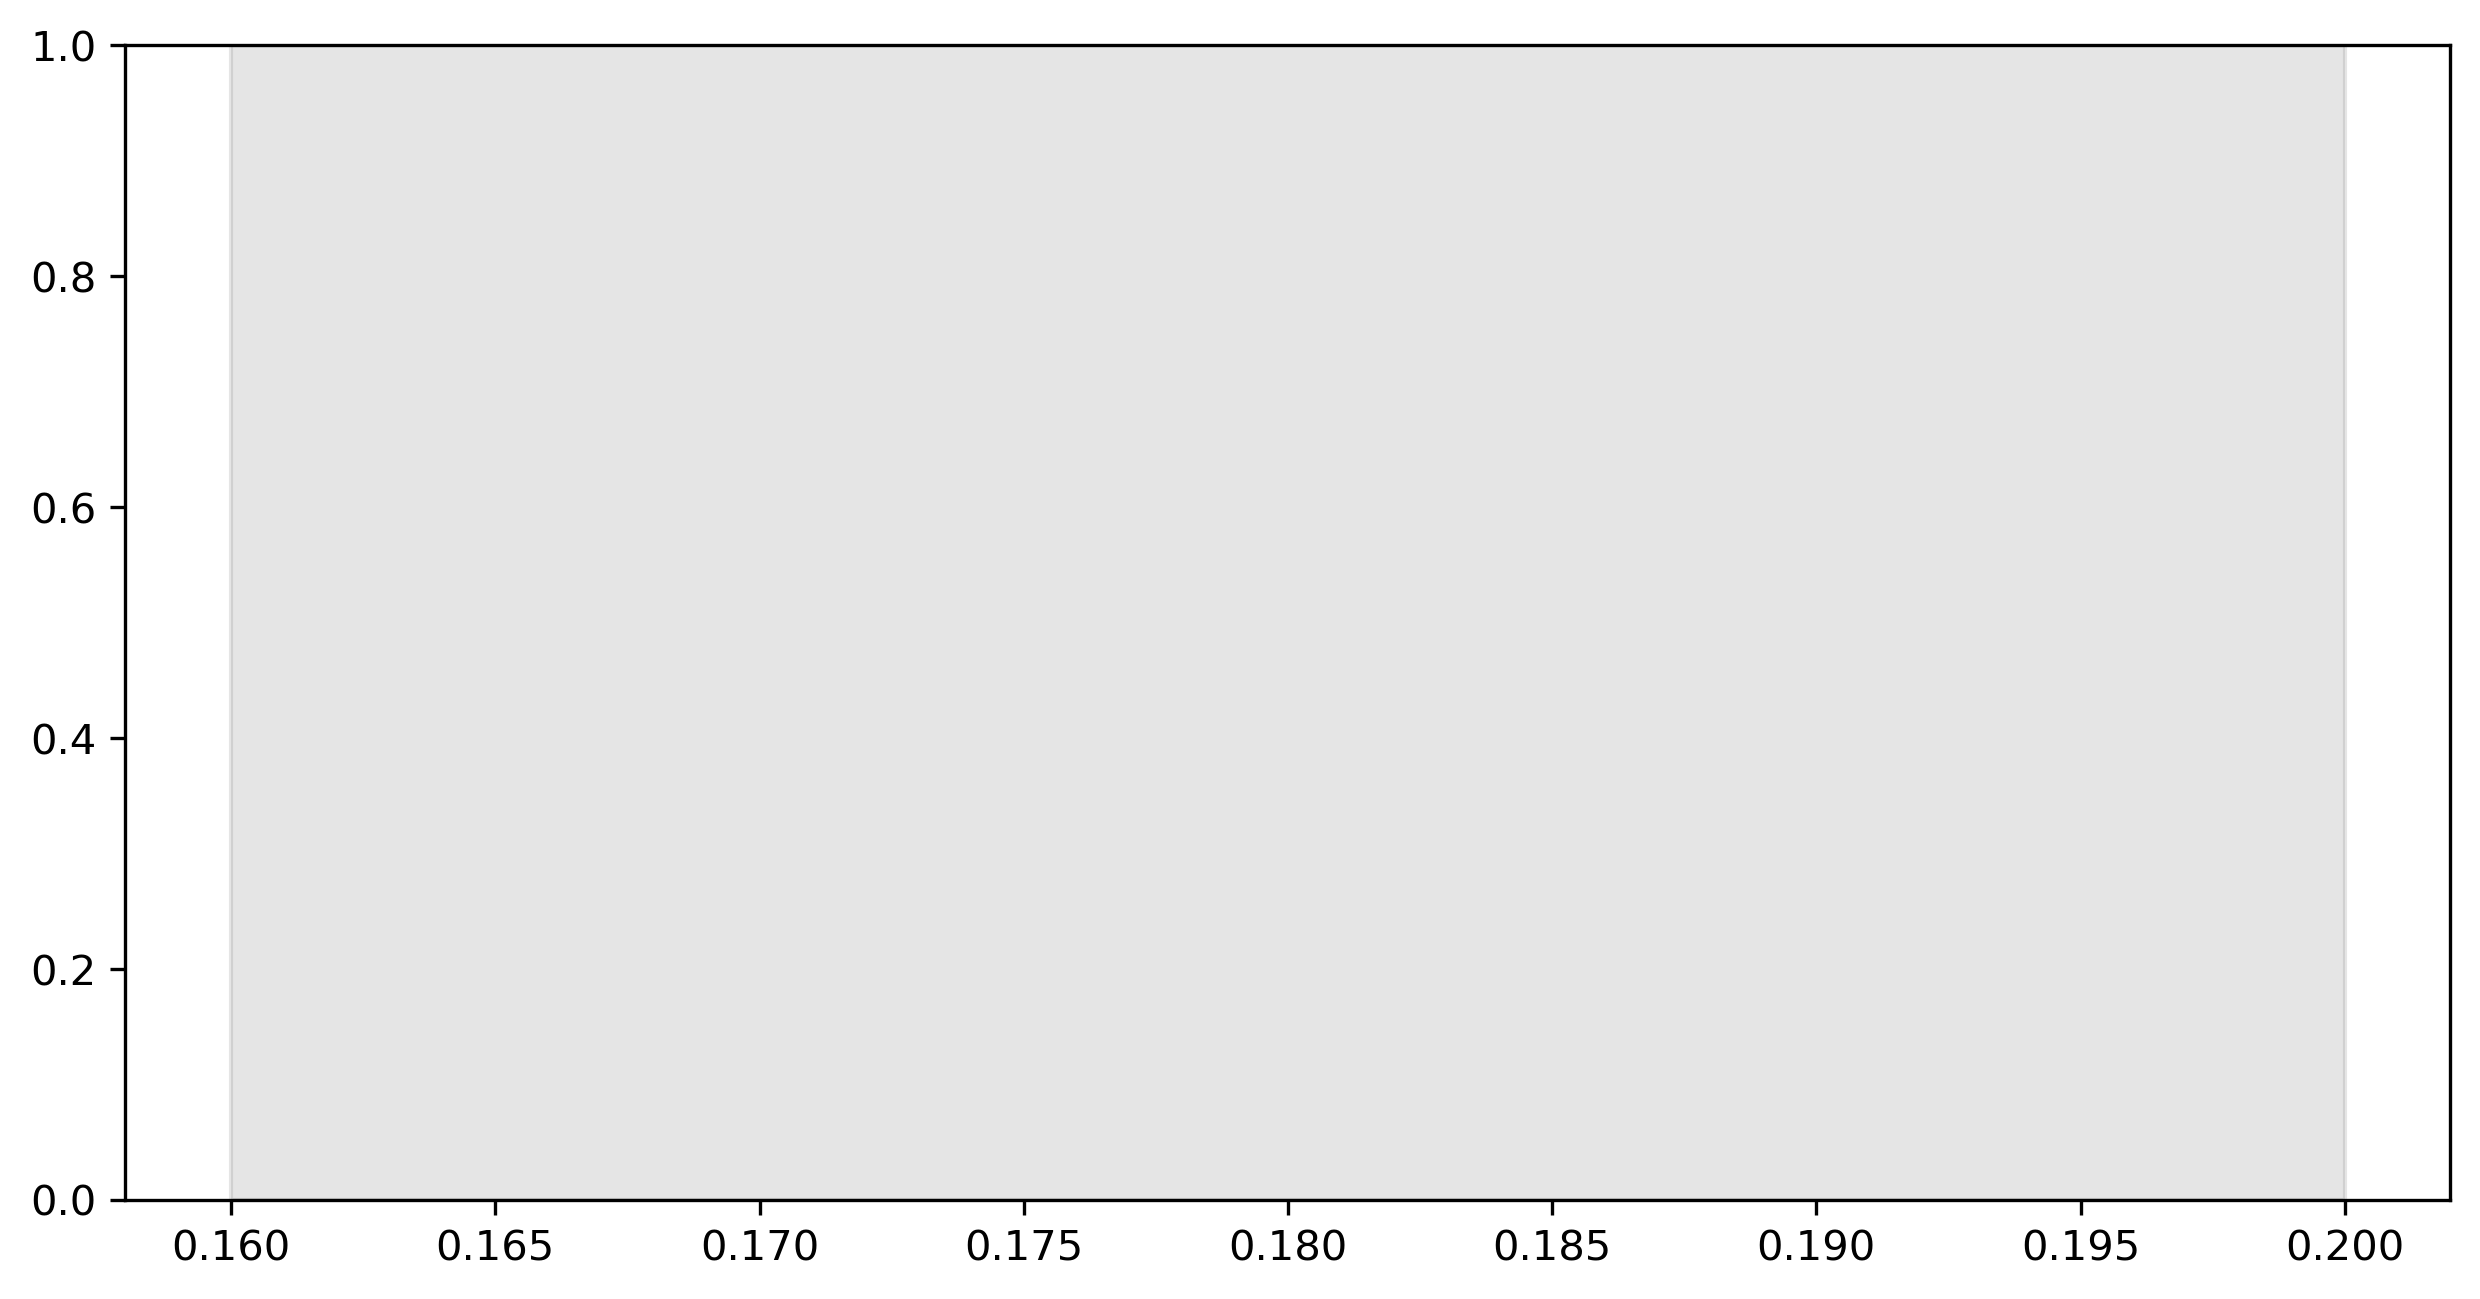

In [95]:
# SAME HERE
# averaging over participants
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, other.mean(axis=0), label="Others", linestyle="-", color=colours[0])
ax.plot(times, white.mean(axis=0), label="White", linestyle="-", color=colours[1])

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP averaged over participants (Fz, Cz, Pz, Oz)")
ax.legend()